In [1]:
#import from top directory
import sys
sys.path.append('../')

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
#from src.datasets import get_input_transform, get_collate_fn
from src.datasets import Physionet2012
from src.models import GP_Sig
from src.utils.train_utils import count_parameters
from src.training import TrainingLoop
from exp.callbacks import LogTrainingLoss
from torch.utils.data import DataLoader
import gc
import gpytorch
from src.utils.train_utils import augment_labels

In [3]:
# Parameter for test setting:
data_format  = 'GP'
grid_spacing = 0.1 #1.
device = 'cpu'


In [4]:
from IPython import embed

"""Module with util functions."""
from functools import partial
import os
from typing import List
import pandas as pd
import numpy as np
import torch
from collections import defaultdict


# Customize input transform for debuggin!
def to_gpytorch_format(d, grid_spacing=1.0):
    """Convert dictionary with data into the gpytorch format.

    Args:
        d: Dictionary with at least the following keys: time, values

    Returns:
        Dictionary where time and values are replaced with inputs, values and
        indices.

    """
    #embed(); print(1)##
    time = d['time']
    del d['time']
    values = d['values']
    valid_indices = np.where(np.isfinite(values))
    #embed(); print(2)##
    inputs = time[valid_indices[0]]
    values_compact = values[valid_indices]
    indexes = valid_indices[1]
    d['inputs'] = inputs
    d['values'] = values_compact
    d['indices'] = indexes[..., np.newaxis]
    #embed(); print(3)##
    # Compute test points
    max_input = np.max(inputs[:, 0])
    min_input = np.min(inputs[:, 0])
    #embed(); print(4)##
    n_tasks = values.shape[-1]
    test_inputs = np.arange(min_input, max_input + grid_spacing, grid_spacing)
    len_test_grid = len(test_inputs)
    test_inputs = np.tile(test_inputs, n_tasks)
    test_indices = np.repeat(np.arange(n_tasks), len_test_grid)
    if n_tasks < 36:
        print(f'n_tasks is {n_tasks} and smaller than 36!')
    #embed(); print(5)##
    d['test_inputs'] = test_inputs[:, np.newaxis].astype(np.float32)
    d['test_indices'] = test_indices[:, np.newaxis].astype(np.int64)
    #embed(); print(6)##
    return d

def get_input_transform(data_format, grid_spacing):
    """
    Util function to return input transform of dataset, depending on data format
    Args:
        - data_format: which data format to use depends on model
            'GP' for models using gpytorch
            'imputed' for imputed baselines
        - grid_spacing: number of hours between each query point / or imputed point depending on format
    """
    if data_format == 'GP':
        input_transform = partial(to_gpytorch_format, grid_spacing=grid_spacing)
        return input_transform
    elif data_format == 'imputed':
        raise NotImplementedError('Pre-Imputed dataset not implemented yet!')
    else:
        raise ValueError('No valid data format provided!')
        


In [5]:
def get_max_shape(l):
    """Get maximum shape for all numpy arrays in list.

    Args:
        l: List of numpy arrays.

    Returns:
        Shape containing the max shape along each axis.

    """
    shapes = np.array([el.shape for el in l])
    return np.max(shapes, axis=0)


def dict_collate_fn(instances, padding_values=None):
    """Collate function for a list of dictionaries.

    Args:
        instances: List of dictionaries with same keys.
        padding_values: Dict with a subset of keys from instances, mapping them
            to the values that should be used for padding. If not defined 0 is
            used.

    Returns:
        Dictionary with instances padded and combined into tensors.

    """
    # Convert list of dicts to dict of lists
    dict_of_lists = {
        key: [d[key] for d in instances]
        for key in instances[0].keys()
    }

    # Pad instances to max shape
    max_shapes = {
        key: get_max_shape(value) for key, value in dict_of_lists.items()
    }
    #print(max_shapes)
    padded_output = defaultdict(list)
    # Pad with 0 in case not otherwise defined
    padding_values = padding_values if padding_values else {}
    padding_values = defaultdict(lambda: 0., padding_values.items())
    for key, max_shape in max_shapes.items():
        for instance in dict_of_lists[key]:
            #print('key', key)
            #print('shape', instance.shape)
            #print('instance', instance)
            instance_shape = np.array(instance.shape)
            padding_shape = max_shape - instance_shape
            # Numpy wants the padding in the form before, after so we need to
            # prepend zeros
            padding = np.stack(
                [np.zeros_like(padding_shape), padding_shape], axis=1)
            padded = np.pad(
                instance,
                padding,
                mode='constant',
                constant_values=padding_values[key]
            )
            padded_output[key].append(padded)

    # Combine instances into individual arrays
    combined = {
        key: torch.tensor(np.stack(values, axis=0))
        for key, values in padded_output.items()
    }

    return combined

def get_collate_fn(data_format, n_input_dims):
    """
    Util function to retrun collate_fn which might depend on data format / used model
    Args:
        - data_format: which data format to use depends on model
            'GP' for models using gpytorch
            'imputed' for imputed baselines
        - n_input_dims: number of input dims, the gpytorch implementation uses a dummy task for padded
            values in the batch tensor (due to zero indexing it's exactly n_input_dims)
    """
    if data_format == 'GP':
        collate_fn = partial(
            dict_collate_fn,
            padding_values={
                'indices': n_input_dims,
                'test_indices': n_input_dims
            }
        )
        return collate_fn
    elif data_format == 'imputed':
        raise NotImplementedError('Pre-Imputed dataset not implemented yet!')
    else:
        raise ValueError('No valid data format provided!')

## Set up dataset:


In [6]:
#Define dataset transform:
input_transform = get_input_transform(data_format, grid_spacing)
train_dataset = Physionet2012(split = 'training', transform = input_transform)

In [7]:
#Check if any raw instance has wrong shape (and wrong test_indices)
for i in np.arange(len(train_dataset)):
    print(i)
    x = train_dataset[i]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078


KeyboardInterrupt: 

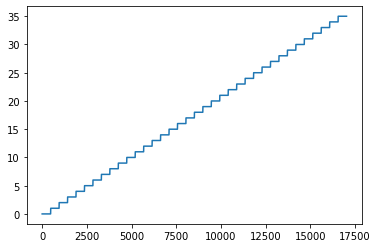

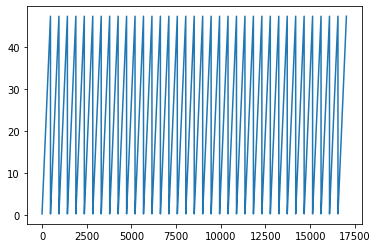

In [8]:
plt.plot(train_dataset[0]['test_indices'])
plt.figure() 
plt.plot(train_dataset[0]['test_inputs'])

## Customizing Model classes for returning intermediate tensors

In [9]:
# Exact Hadamard Multi-task Gaussian Process Model
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, output_device, num_tasks=2, n_devices=1, kernel='rbf'):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.output_device = output_device
        self.mean_module = gpytorch.means.ConstantMean()
        valid_kernels = ['rbf', 'ou']
        if kernel not in valid_kernels:
            raise ValueError(f'parsed kernel: {kernel} not among implemented kernels: {valid_kernels}')
        elif kernel == 'rbf':
            base_covar_module = gpytorch.kernels.RBFKernel()
        elif kernel == 'ou':
            base_covar_module = gpytorch.kernels.MaternKernel(nu=0.5)

        if n_devices > 1: #in multi-gpu setting
            self.covar_module = gpytorch.kernels.MultiDeviceKernel(
                base_covar_module, device_ids=range(n_devices),
                output_device=self.output_device)
            #self.task_covar_module = gpytorch.kernels.IndexKernel(num_tasks=num_tasks, rank=3)
            base_task_covar_module = gpytorch.kernels.IndexKernel(num_tasks=num_tasks, rank=3)
            self.task_covar_module = gpytorch.kernels.MultiDeviceKernel(
                base_task_covar_module, device_ids=range(n_devices),
                output_device=self.output_device)
        else:
            self.covar_module = base_covar_module #gpytorch.kernels.RBFKernel()
            self.task_covar_module = gpytorch.kernels.IndexKernel(num_tasks=num_tasks, rank=3)

    def forward(self,x,i):
        mean_x = self.mean_module(x)

        # Get input-input covariance
        covar_x = self.covar_module(x)
        # Get task-task covariance
        covar_i = self.task_covar_module(i)
        # Multiply the two together to get the covariance we want
        covar = covar_x.mul(covar_i)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar)


# MGP Layer for Neural Network using MultitaskGPModel
class MGP_Layer(MultitaskGPModel):
    def __init__(self,likelihood, num_tasks, n_devices, output_device, kernel):
        super().__init__(None, None, likelihood, output_device, num_tasks, n_devices, kernel)
        #we don't intialize with train data for more flexibility
        likelihood.train()

    def forward(self, inputs, indices):
        return super(MGP_Layer, self).forward(inputs, indices)

    def condition_on_train_data(self, inputs, indices, values):
        self.set_train_data(inputs=(inputs, indices), targets=values, strict=False)
        
# Custom GP Adapter:
# MGP Adapter
class GPAdapter(nn.Module):
    def __init__(self, clf, n_input_dims, n_mc_smps, sampling_type, *gp_params):
        super(GPAdapter, self).__init__()
        self.n_mc_smps = n_mc_smps
        # num_tasks includes dummy task for padedd zeros
        self.n_tasks = gp_params[1] - 1
        self.mgp = MGP_Layer(*gp_params)
        self.clf = clf #(self.n_tasks)
        #more generic would be something like: self.clf = clf(n_input_dims) #e.g. SimpleDeepModel(n_input_dims)
        self.sampling_type = sampling_type # 'monte_carlo', 'moments'

    def forward(self, *data):
        """
        The GP Adapter takes input data as a list of 5 torch tensors (3 for train points, 2 for prediction points)
            - inputs: input points of time grid (batch, timesteps, 1)
            - indices: indices of task or channels (batch, timesteps, 1)
            - values: values (or targets) of actual observations (batch, timesteps)
            - test_inputs: query points in time (batch, timesteps, 1)
            - test_indices: query tasks for given point in time (batch, timesteps, 1)
        """
        self.posterior = self.gp_forward(*data)

        #Get regularly-spaced "latent" timee series Z:
        if self.sampling_type == 'monte_carlo':
            #draw sample in MGP format (all tasks in same dimension)
            Z = self.draw_samples(self.posterior, self.n_mc_smps)
        elif self.sampling_type == 'moments':
            #feed moments of GP posterior to classifier (mean, variance)
            Z = self.feed_moments(self.posterior)

        #reshape such that tensor has timesteps and tasks/channels in independent dimensions for Signature network:
        Z, Z_raw = self.channel_reshape(Z)

        return self.clf(Z), Z, Z_raw

    def gp_forward(self, *data):
        #Unpack data:
        inputs, indices, values, test_inputs, test_indices = [*data]

        #Condition MGP on training data:
        self.mgp.condition_on_train_data(inputs, indices, values)

        #Return posterior distribution:
        return self.mgp(test_inputs, test_indices)

    def draw_samples(self, posterior, n_mc_smps):
        #Draw monte carlo samples (with gradient) from posterior:
        return posterior.rsample(torch.Size([n_mc_smps])) #mc_samples form a new (outermost) dimension

    def feed_moments(self, posterior):
        """
        Get mean and variance of posterior and concatenate them along the channel dimension for feeding them to feed the clf
        """
        mean = posterior.mean
        var = posterior.variance
        return torch.cat([ mean, var ], axis=-1)

    def parameters(self):
        return list(self.mgp.parameters()) + list(self.clf.parameters())

    def train(self, mode=True):
        """
        only set classifier to train mode, MGP always in eval mode for posterior draws
        """
        if mode:
            super().train()
            self.mgp.eval()
        else:
            super().train(False)

    def eval(self):
        """
        eval simply calls eval of super class (which in turn activates train with False)
        """
        super().eval()

    def channel_reshape(self, X):
        """
        reshaping function required as hadamard MGP's output format is not directly compatible with subsequent network
        """
        #first check if we have to doubele the number of channels
        if self.sampling_type == 'moments':
            channel_dim = 2*self.n_tasks
        else:
            channel_dim = self.n_tasks

        X_reshaped = X.view(X.shape[:-1]                    #batch-dim (or mc_smp and batch_dim)
            + torch.Size([channel_dim])                     #channel-dim
            + torch.Size([int(X.shape[-1] / channel_dim)])  #time steps dim
        )
        # finally, swap last two dims: timestep and channel dim for Signature Augmentations
        X_reshaped = X_reshaped.transpose(-2,-1)
        
        if self.sampling_type == 'monte_carlo':
            X_reshaped = X_reshaped.flatten(0,1) #SigNet requires 3 dim setup, so we flatten out the mc dimension with batch
        return X_reshaped, X
    
from src.models.deep_models import DeepSignatureModel

class GP_Sig(nn.Module):
    def __init__(self, n_input_dims, out_dimension, sampling_type, n_mc_smps,
            n_devices, output_device, sig_depth=2, kernel='rbf'):
        super(GP_Sig, self).__init__()

        #safety guard:
        self.sampling_type = sampling_type
        if self.sampling_type == 'moments':
            n_mc_smps = 1
            # the classifier receives mean and variance of GPs posterior
            clf_input_dims = 2*n_input_dims
        else:
            clf_input_dims = n_input_dims

        likelihood = gpytorch.likelihoods.GaussianLikelihood().to(
                        output_device, non_blocking=True)
        clf = DeepSignatureModel(   in_channels=clf_input_dims,
                                    out_dimension=out_dimension,
                                    sig_depth=sig_depth
                                )

        self.model = GPAdapter( clf,
                                None,
                                n_mc_smps,
                                sampling_type,
                                likelihood,
                                n_input_dims + 1,
                                n_devices,
                                output_device,
                                kernel
        )

    def forward(self, *data):
        return self.model(*data)

## Setting up parameters for Model

In [10]:
#Determine number of input dimensions as GP-Sig models requires this parameter for initialisation
n_input_dims = train_dataset.measurement_dims
out_dimension = train_dataset.n_classes
collate_fn = get_collate_fn(data_format, n_input_dims)
sampling_type = 'monte_carlo'
n_mc_smps = 1 # for debugging
n_devices = 1
output_device = 'cpu'

## Initialize a standard GP-Sig adapter

In [11]:
model = GP_Sig(n_input_dims, 
               out_dimension, 
               sampling_type, 
               n_mc_smps, 
               n_devices, 
               output_device)
model.to(device)
print(f'Number of trainable Parameters: {count_parameters(model)}')

Number of trainable Parameters: 56660


In [12]:
# Loss function:
loss_fn = torch.nn.BCELoss()

# Parameters for Training Loop

In [13]:
n_epochs = 1
batch_size = 32
learning_rate = 0.001
max_root = 25
weight_decay = 1e-3
callbacks = None
virtual_batch_size = None

In [269]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn,
                                  shuffle=False, pin_memory=True)

In [270]:
d = next(iter(train_loader))

{'values': array([629]), 'label': array([1]), 'inputs': array([629,   1]), 'indices': array([629,   1]), 'test_inputs': array([1764,    1]), 'test_indices': array([1764,    1])}
key values
shape (629,)
instance [-6.26262903e-01 -1.77194834e-01  2.13781095e+00 -8.93230081e-01
  7.49499977e-01  1.24933314e+00 -5.73551953e-02 -6.11437142e-01
 -2.15096653e-01  6.76464140e-02  1.80696976e+00  2.36023736e+00
 -3.61364521e-02  2.78908849e+00  2.41647315e+00 -4.37593460e-02
 -2.30931193e-01  1.58872116e+00  8.83086696e-02 -3.76610309e-02
 -3.85529041e-01  8.89903188e-01  2.36999202e+00  0.00000000e+00
 -4.71808970e-01 -8.31067801e-01 -2.82165945e-01 -2.41061956e-01
 -2.41054268e+01  2.78582573e-01 -2.10127997e+00 -7.77297735e-01
  3.65696818e-01  1.16013043e-01 -5.17384887e-01 -2.22105682e-01
  5.03700018e-01 -7.77297735e-01  6.01283312e-01  2.74713039e-01
 -4.47803676e-01  6.53778315e-01 -6.69757664e-01  4.83490050e-01
  1.16013043e-01 -4.47803676e-01  8.03856611e-01 -6.15987599e-01
  5.42386

key inputs
shape (475, 1)
instance [[ 0.28333333]
 [ 0.28333333]
 [ 0.28333333]
 [ 0.28333333]
 [ 0.28333333]
 [ 0.28333333]
 [ 0.28333333]
 [ 0.38333333]
 [ 0.38333333]
 [ 0.38333333]
 [ 0.38333333]
 [ 0.38333333]
 [ 0.38333333]
 [ 0.38333333]
 [ 0.38333333]
 [ 0.38333333]
 [ 0.38333333]
 [ 0.38333333]
 [ 0.38333333]
 [ 0.38333333]
 [ 0.38333333]
 [ 0.78333336]
 [ 0.78333336]
 [ 0.78333336]
 [ 0.78333336]
 [ 1.2833333 ]
 [ 1.2833333 ]
 [ 1.2833333 ]
 [ 1.2833333 ]
 [ 1.2833333 ]
 [ 2.2833333 ]
 [ 2.2833333 ]
 [ 2.2833333 ]
 [ 2.2833333 ]
 [ 2.2833333 ]
 [ 2.5833333 ]
 [ 2.5833333 ]
 [ 2.5833333 ]
 [ 2.5833333 ]
 [ 2.7833333 ]
 [ 2.7833333 ]
 [ 2.7833333 ]
 [ 2.7833333 ]
 [ 3.2833333 ]
 [ 3.2833333 ]
 [ 3.2833333 ]
 [ 3.2833333 ]
 [ 3.2833333 ]
 [ 3.2833333 ]
 [ 3.2833333 ]
 [ 4.2833333 ]
 [ 4.2833333 ]
 [ 4.2833333 ]
 [ 4.2833333 ]
 [ 4.2833333 ]
 [ 5.0333333 ]
 [ 5.0333333 ]
 [ 5.0333333 ]
 [ 5.0333333 ]
 [ 5.0333333 ]
 [ 5.2833333 ]
 [ 5.2833333 ]
 [ 5.2833333 ]
 [ 5.2833333 ]
 [ 5.

 [35]]
key test_indices
shape (1656, 1)
instance [[ 0]
 [ 0]
 [ 0]
 ...
 [35]
 [35]
 [35]]
key test_indices
shape (1692, 1)
instance [[ 0]
 [ 0]
 [ 0]
 ...
 [35]
 [35]
 [35]]
key test_indices
shape (1764, 1)
instance [[ 0]
 [ 0]
 [ 0]
 ...
 [35]
 [35]
 [35]]
key test_indices
shape (1728, 1)
instance [[ 0]
 [ 0]
 [ 0]
 ...
 [35]
 [35]
 [35]]
key test_indices
shape (1764, 1)
instance [[ 0]
 [ 0]
 [ 0]
 ...
 [35]
 [35]
 [35]]
key test_indices
shape (1764, 1)
instance [[ 0]
 [ 0]
 [ 0]
 ...
 [35]
 [35]
 [35]]
key test_indices
shape (1728, 1)
instance [[ 0]
 [ 0]
 [ 0]
 ...
 [35]
 [35]
 [35]]
key test_indices
shape (1764, 1)
instance [[ 0]
 [ 0]
 [ 0]
 ...
 [35]
 [35]
 [35]]
key test_indices
shape (1764, 1)
instance [[ 0]
 [ 0]
 [ 0]
 ...
 [35]
 [35]
 [35]]
key test_indices
shape (1728, 1)
instance [[ 0]
 [ 0]
 [ 0]
 ...
 [35]
 [35]
 [35]]
key test_indices
shape (1728, 1)
instance [[ 0]
 [ 0]
 [ 0]
 ...
 [35]
 [35]
 [35]]
key test_indices
shape (1764, 1)
instance [[ 0]
 [ 0]
 [ 0]
 ...
 [35

In [266]:
d.keys()

dict_keys(['values', 'label', 'inputs', 'indices', 'test_inputs', 'test_indices'])

In [258]:
d['test_indices'][2]

tensor([[ 0],
        [ 0],
        [ 0],
        ...,
        [36],
        [36],
        [36]])

In [14]:

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn,
                                  shuffle=False, pin_memory=True, num_workers=8)
n_batches = len(train_loader)
optimizer = torch.optim.Adam(
            model.parameters(), lr=learning_rate,
            weight_decay=weight_decay)
optimizer.zero_grad()

#d = next(iter(train_loader))
d = list(train_loader)[0]
if n_mc_smps > 1:
    y_true = augment_labels(d['label'], n_mc_smps)
else:
    y_true = d['label']
#GP format of data:
inputs = d['inputs']
indices = d['indices']
values = d['values']
test_inputs = d['test_inputs']
test_indices = d['test_indices']

# Set model into training mode and feed forward
model.train()



{'values': array([629]), 'label': array([1]), 'inputs': array([629,   1]), 'indices': array([629,   1]), 'test_inputs': array([17280,     1]), 'test_indices': array([17280,     1])}
{'values': array([650]), 'label': array([1]), 'inputs': array([650,   1]), 'indices': array([650,   1]), 'test_inputs': array([17316,     1]), 'test_indices': array([17316,     1])}
{'values': array([640]), 'label': array([1]), 'inputs': array([640,   1]), 'indices': array([640,   1]), 'test_inputs': array([17244,     1]), 'test_indices': array([17244,     1])}
{'values': array([578]), 'label': array([1]), 'inputs': array([578,   1]), 'indices': array([578,   1]), 'test_inputs': array([17244,     1]), 'test_indices': array([17244,     1])}
{'values': array([645]), 'label': array([1]), 'inputs': array([645,   1]), 'indices': array([645,   1]), 'test_inputs': array([17244,     1]), 'test_indices': array([17244,     1])}
{'values': array([601]), 'label': array([1]), 'inputs': array([601,   1]), 'indices': arra

{'values': array([772]), 'label': array([1]), 'inputs': array([772,   1]), 'indices': array([772,   1]), 'test_inputs': array([17316,     1]), 'test_indices': array([17316,     1])}
{'values': array([728]), 'label': array([1]), 'inputs': array([728,   1]), 'indices': array([728,   1]), 'test_inputs': array([17244,     1]), 'test_indices': array([17244,     1])}
{'values': array([817]), 'label': array([1]), 'inputs': array([817,   1]), 'indices': array([817,   1]), 'test_inputs': array([17244,     1]), 'test_indices': array([17244,     1])}
{'values': array([584]), 'label': array([1]), 'inputs': array([584,   1]), 'indices': array([584,   1]), 'test_inputs': array([17280,     1]), 'test_indices': array([17280,     1])}
{'values': array([1028]), 'label': array([1]), 'inputs': array([1028,    1]), 'indices': array([1028,    1]), 'test_inputs': array([17316,     1]), 'test_indices': array([17316,     1])}
{'values': array([575]), 'label': array([1]), 'inputs': array([575,   1]), 'indices':

{'values': array([767]), 'label': array([1]), 'inputs': array([767,   1]), 'indices': array([767,   1]), 'test_inputs': array([17280,     1]), 'test_indices': array([17280,     1])}
{'values': array([724]), 'label': array([1]), 'inputs': array([724,   1]), 'indices': array([724,   1]), 'test_inputs': array([17280,     1]), 'test_indices': array([17280,     1])}
{'values': array([567]), 'label': array([1]), 'inputs': array([567,   1]), 'indices': array([567,   1]), 'test_inputs': array([17316,     1]), 'test_indices': array([17316,     1])}
{'values': array([638]), 'label': array([1]), 'inputs': array([638,   1]), 'indices': array([638,   1]), 'test_inputs': array([17244,     1]), 'test_indices': array([17244,     1])}
{'values': array([632]), 'label': array([1]), 'inputs': array([632,   1]), 'indices': array([632,   1]), 'test_inputs': array([17280,     1]), 'test_indices': array([17280,     1])}
{'values': array([613]), 'label': array([1]), 'inputs': array([613,   1]), 'indices': arra

{'values': array([860]), 'label': array([1]), 'inputs': array([860,   1]), 'indices': array([860,   1]), 'test_inputs': array([17244,     1]), 'test_indices': array([17244,     1])}
{'values': array([779]), 'label': array([1]), 'inputs': array([779,   1]), 'indices': array([779,   1]), 'test_inputs': array([17280,     1]), 'test_indices': array([17280,     1])}
{'values': array([743]), 'label': array([1]), 'inputs': array([743,   1]), 'indices': array([743,   1]), 'test_inputs': array([17316,     1]), 'test_indices': array([17316,     1])}
{'values': array([715]), 'label': array([1]), 'inputs': array([715,   1]), 'indices': array([715,   1]), 'test_inputs': array([17244,     1]), 'test_indices': array([17244,     1])}
{'values': array([718]), 'label': array([1]), 'inputs': array([718,   1]), 'indices': array([718,   1]), 'test_inputs': array([17280,     1]), 'test_indices': array([17280,     1])}
{'values': array([586]), 'label': array([1]), 'inputs': array([586,   1]), 'indices': arra

{'values': array([691]), 'label': array([1]), 'inputs': array([691,   1]), 'indices': array([691,   1]), 'test_inputs': array([17280,     1]), 'test_indices': array([17280,     1])}
{'values': array([760]), 'label': array([1]), 'inputs': array([760,   1]), 'indices': array([760,   1]), 'test_inputs': array([17244,     1]), 'test_indices': array([17244,     1])}
{'values': array([916]), 'label': array([1]), 'inputs': array([916,   1]), 'indices': array([916,   1]), 'test_inputs': array([17244,     1]), 'test_indices': array([17244,     1])}
{'values': array([715]), 'label': array([1]), 'inputs': array([715,   1]), 'indices': array([715,   1]), 'test_inputs': array([17280,     1]), 'test_indices': array([17280,     1])}
{'values': array([605]), 'label': array([1]), 'inputs': array([605,   1]), 'indices': array([605,   1]), 'test_inputs': array([17208,     1]), 'test_indices': array([17208,     1])}
{'values': array([735]), 'label': array([1]), 'inputs': array([735,   1]), 'indices': arra

GP_Sig(
  (model): GPAdapter(
    (mgp): MGP_Layer(
      (likelihood): GaussianLikelihood(
        (quadrature): GaussHermiteQuadrature1D()
        (noise_covar): HomoskedasticNoise(
          (raw_noise_constraint): GreaterThan(1.000E-04)
        )
      )
      (mean_module): ConstantMean()
      (covar_module): RBFKernel(
        (raw_lengthscale_constraint): Positive()
      )
      (task_covar_module): IndexKernel(
        (raw_var_constraint): Positive()
      )
    )
    (clf): DeepSignatureModel(
      (augment1): Augment(
        activation=<function relu at 0x11085a440>, include_original=True, include_time=True
        (convs): ModuleList(
          (0): Conv1d(36, 8, kernel_size=(4,), stride=(1,))
          (1): Conv1d(8, 8, kernel_size=(1,), stride=(1,))
          (2): Conv1d(8, 4, kernel_size=(1,), stride=(1,))
        )
      )
      (signature1): Signature(depth=2, stream=True, inverse=False)
      (augment2): Augment(
        activation=<function relu at 0x11085a440>, 

In [ ]:
with gpytorch.settings.fast_pred_var(), gpytorch.settings.max_root_decomposition_size(max_root):
    logits, Z, Z_raw = model( inputs,
                    indices,
                    values,
                    test_inputs,
                    test_indices)

In [ ]:
instance = 2

In [ ]:
ti = test_indices.detach().numpy()
lab = y_true.numpy().astype(bool)

In [ ]:
plt.plot(inputs[instance])

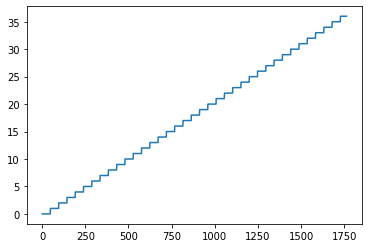

In [177]:
plt.plot(test_indices[instance])

In [179]:
(test_indices[instance])

tensor([[ 0],
        [ 0],
        [ 0],
        ...,
        [36],
        [36],
        [36]])

In [15]:
#Z_raw[0,0]
first = Z_raw[0,instance].detach().numpy()
first.shape

(1764,)

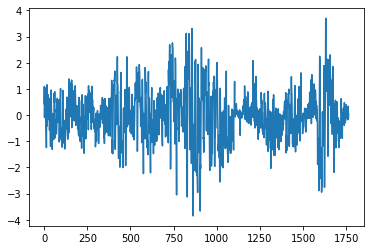

In [16]:
plt.plot(first)

In [17]:
ind = test_indices[2].detach().flatten() # task indices of query points

In [18]:
ind

tensor([ 0,  0,  0,  ..., 36, 36, 36])

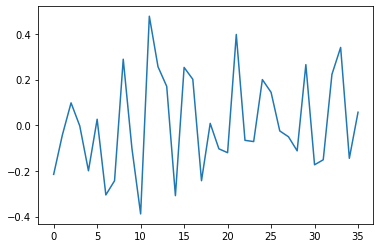

In [19]:
plt.plot(first[ind == 36])

In [20]:
for name, param in model.named_parameters():
    print(name, param)

model.mgp.likelihood.noise_covar.raw_noise Parameter containing:
tensor([0.], requires_grad=True)
model.mgp.mean_module.constant Parameter containing:
tensor([0.], requires_grad=True)
model.mgp.covar_module.raw_lengthscale Parameter containing:
tensor([[0.]], requires_grad=True)
model.mgp.task_covar_module.covar_factor Parameter containing:
tensor([[-2.3429e-01, -7.5022e-01, -1.3023e+00],
        [ 6.2596e-01,  6.9638e-04,  7.7871e-01],
        [-7.7372e-01, -2.2447e-01,  9.9333e-01],
        [ 1.1407e+00,  1.2861e+00,  7.1399e-01],
        [ 5.6231e-01, -1.2554e+00,  1.9138e-01],
        [ 3.2944e-01,  1.4887e+00,  7.8611e-01],
        [-1.1313e+00, -2.3475e-01,  4.7673e-02],
        [-7.0673e-01, -6.2498e-01, -8.4359e-01],
        [-1.1486e+00,  1.1202e+00, -8.8064e-01],
        [ 2.7379e-01, -6.5624e-01,  1.4436e+00],
        [ 2.8070e-01, -8.0808e-01,  2.3252e-01],
        [ 8.3526e-01,  5.8098e-01, -1.4366e+00],
        [ 1.5045e+00, -1.2636e+00,  4.4719e-01],
        [-9.9892e-01

In [21]:
model.model.mgp.task_covar_module.covar_factor[36:,:] = torch.zeros(3, requires_grad=False)
model.model.mgp.task_covar_module.raw_var[36:] = torch.zeros(1, requires_grad=False)

tensor([0.])

## Do one update step:


In [43]:
y_true = y_true.flatten()
loss = loss_fn(logits, y_true)

# Optimize
optimizer.zero_grad()
loss.backward()
optimizer.step()

/Users/mimoor/.local/share/virtualenvs/GP_Signatures-e2qdpZsN/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


In [28]:
for name, param in model.model.mgp.named_parameters():
    print(name, param)

likelihood.noise_covar.raw_noise Parameter containing:
tensor([0.], requires_grad=True)
mean_module.constant Parameter containing:
tensor([-0.0010], requires_grad=True)
covar_module.raw_lengthscale Parameter containing:
tensor([[-0.0010]], requires_grad=True)
task_covar_module.covar_factor Parameter containing:
tensor([[-0.3336,  1.0195, -0.7260],
        [-0.1702, -1.2716,  0.7840],
        [ 1.4865, -0.3649,  0.0082],
        [ 1.4726, -0.2523, -1.9416],
        [ 0.7752, -0.9497,  0.6931],
        [ 0.7208,  0.0742, -0.5710],
        [ 0.5789,  0.5447,  0.3578],
        [-0.7359,  1.0652, -2.2164],
        [ 0.5315, -0.5724,  0.0331],
        [ 1.1608, -0.6895,  0.6880],
        [-0.4582, -0.4010,  0.3899],
        [ 0.7565, -0.3529, -1.2885],
        [-1.3940,  0.0059, -0.4937],
        [-1.3927,  0.4865,  0.4658],
        [-0.0253, -1.3285,  0.7179],
        [ 0.5536,  0.0060,  0.5704],
        [-0.1239,  1.3670,  0.5232],
        [-1.3291,  0.6895,  1.1981],
        [ 0.0785,  0.

In [30]:
model.model.mgp.task_covar_module.covar_factor

Parameter containing:
tensor([[-0.3336,  1.0195, -0.7260],
        [-0.1702, -1.2716,  0.7840],
        [ 1.4865, -0.3649,  0.0082],
        [ 1.4726, -0.2523, -1.9416],
        [ 0.7752, -0.9497,  0.6931],
        [ 0.7208,  0.0742, -0.5710],
        [ 0.5789,  0.5447,  0.3578],
        [-0.7359,  1.0652, -2.2164],
        [ 0.5315, -0.5724,  0.0331],
        [ 1.1608, -0.6895,  0.6880],
        [-0.4582, -0.4010,  0.3899],
        [ 0.7565, -0.3529, -1.2885],
        [-1.3940,  0.0059, -0.4937],
        [-1.3927,  0.4865,  0.4658],
        [-0.0253, -1.3285,  0.7179],
        [ 0.5536,  0.0060,  0.5704],
        [-0.1239,  1.3670,  0.5232],
        [-1.3291,  0.6895,  1.1981],
        [ 0.0785,  0.9948, -0.7299],
        [-1.4027,  1.0380, -1.4042],
        [ 1.4371,  0.5997,  1.3446],
        [-1.5428,  0.4121,  0.4276],
        [-0.0100,  0.1610,  0.8351],
        [-0.3123, -0.1769, -0.3952],
        [-1.6556, -1.6750,  0.8678],
        [-0.2765,  0.3633,  0.5543],
        [ 1.0412

## Plot one instance (Z imputed overlay with Z-raw)

In [95]:
instance = 2

In [96]:
Z.shape, Z_raw.shape

(torch.Size([32, 49, 36]), torch.Size([1, 32, 1764]))

In [24]:
Z_first = Z[instance].detach().numpy()
Z_raw_first = Z_raw[0,instance].detach().numpy()

In [25]:
Z_raw_first.shape

(1764,)

In [26]:
Z[instance + batch_size*1].detach().numpy().shape

(49, 36)

In [103]:
test_inputs_i = test_inputs[instance]
test_indices_i = test_indices[instance]

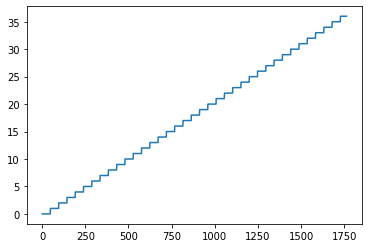

In [28]:
#Get instance i
test_inputs_first = test_inputs[instance].flatten()
test_indices_first = test_indices[instance].flatten()
inputs_first = inputs[instance].flatten()
indices_first = indices[instance].flatten()
values_first = values[instance]

In [29]:
np.unique(test_indices_first)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36])

In [79]:
def plot_instance(instance, Z, Z_raw, test_inputs, 
                  test_indices, inputs, indices, 
                  values, show_channels='all', show_type=['gp', 'gp_reshaped', 'input'], 
                 n_mc_smps=1, batch_size=32):
    """
    Plot GP posterior sample of patient
    - Z_raw: posterior draw (in raw format before reshaping for clf)
    - test_inputs: (time grid to query the GP)
    - test_indices: tasks indices to query the GP
    """
    test_inputs_i = test_inputs[instance].flatten() # query grid points 
    test_indices_i = test_indices[instance].flatten() # query task indices
    inputs_i = inputs[instance].flatten() # training time points
    indices_i = indices[instance].flatten() # training task indices
    values_i = values[instance] # training y values

    if show_channels == 'all':
        show_channels = np.unique(test_indices_i)
        n_channels = len(show_channels)
    else:
        n_channels = len(show_channels)
    fig, ax = plt.subplots(nrows=n_channels, figsize=(5*n_channels, 4*n_channels))

    for sample in np.arange(n_mc_smps):
        #first extract data of instance:
        Z_i = Z[instance + batch_size*sample]
        Z_i = Z_i.detach().numpy() #reshaped GP draw
        Z_raw_i = Z_raw[sample,instance] #raw GP draw
        Z_raw_i = Z_raw_i.detach().numpy()

        for i, channel in enumerate(show_channels):
            if sample == 0:
                if 'input' in show_type:
                    plot_channel(ax[i], values_i, inputs_i, indices_i, channel, color='darkblue')
            if 'gp' in show_type:
                plot_channel(ax[i], Z_raw_i, test_inputs_i, test_indices_i, channel)
            if 'gp_reshaped' in show_type:
                plot_reshaped_channel(ax[i], Z_i, test_inputs_i, channel, color='green')

In [80]:
def plot_channel(ax, Z_raw, test_inputs, test_indices, channel, color='red'):
    x = test_inputs[test_indices == channel]
    y = Z_raw[test_indices == channel]
    ax.plot(x,y, '-o', color=color)
    ax.set_xlabel(f'Channel {channel}')

In [81]:
def plot_reshaped_channel(ax, Z, test_inputs, channel, color='green'):
    x = np.unique(test_inputs)
    print(f'Z shape in plot reshaped: {Z.shape}')
    y = Z[:,channel]
    ax.plot(x,y, '-o', color=color)

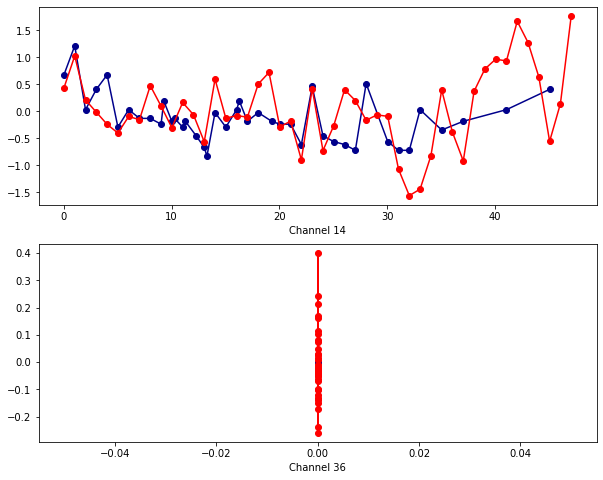

In [82]:
plot_instance(2, Z, Z_raw, test_inputs, 
              test_indices, inputs, indices, 
              values, show_channels=[14, 36], 
              show_type=['input', 'gp'],
              n_mc_smps=n_mc_smps,
              batch_size=batch_size)

In [69]:
np.unique(test_indices[2])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36])

tensor([[ 0],
        [ 0],
        [ 0],
        ...,
        [35],
        [35],
        [35]])

Z shape in plot reshaped: (49, 36)
Z shape in plot reshaped: (49, 36)


IndexError: index 36 is out of bounds for axis 1 with size 36

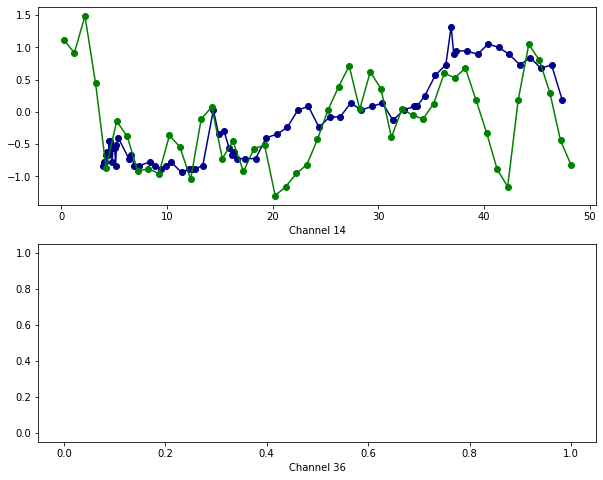

In [112]:
plot_instance(0, Z, Z_raw, test_inputs, 
              test_indices, inputs, indices, 
              values, show_channels=[14,36], #[14, 36] 
              show_type=['input', 'gp_reshaped'],
              n_mc_smps=n_mc_smps,
              batch_size=batch_size)

In [242]:
np.unique(test_inputs_first)

array([ 0.25,  1.25,  2.25,  3.25,  4.25,  5.25,  6.25,  7.25,  8.25,
        9.25, 10.25, 11.25, 12.25, 13.25, 14.25, 15.25, 16.25, 17.25,
       18.25, 19.25, 20.25, 21.25, 22.25, 23.25, 24.25, 25.25, 26.25,
       27.25, 28.25, 29.25, 30.25, 31.25, 32.25, 33.25, 34.25, 35.25,
       36.25, 37.25, 38.25, 39.25, 40.25, 41.25, 42.25, 43.25, 44.25,
       45.25, 46.25, 47.25, 48.25], dtype=float32)

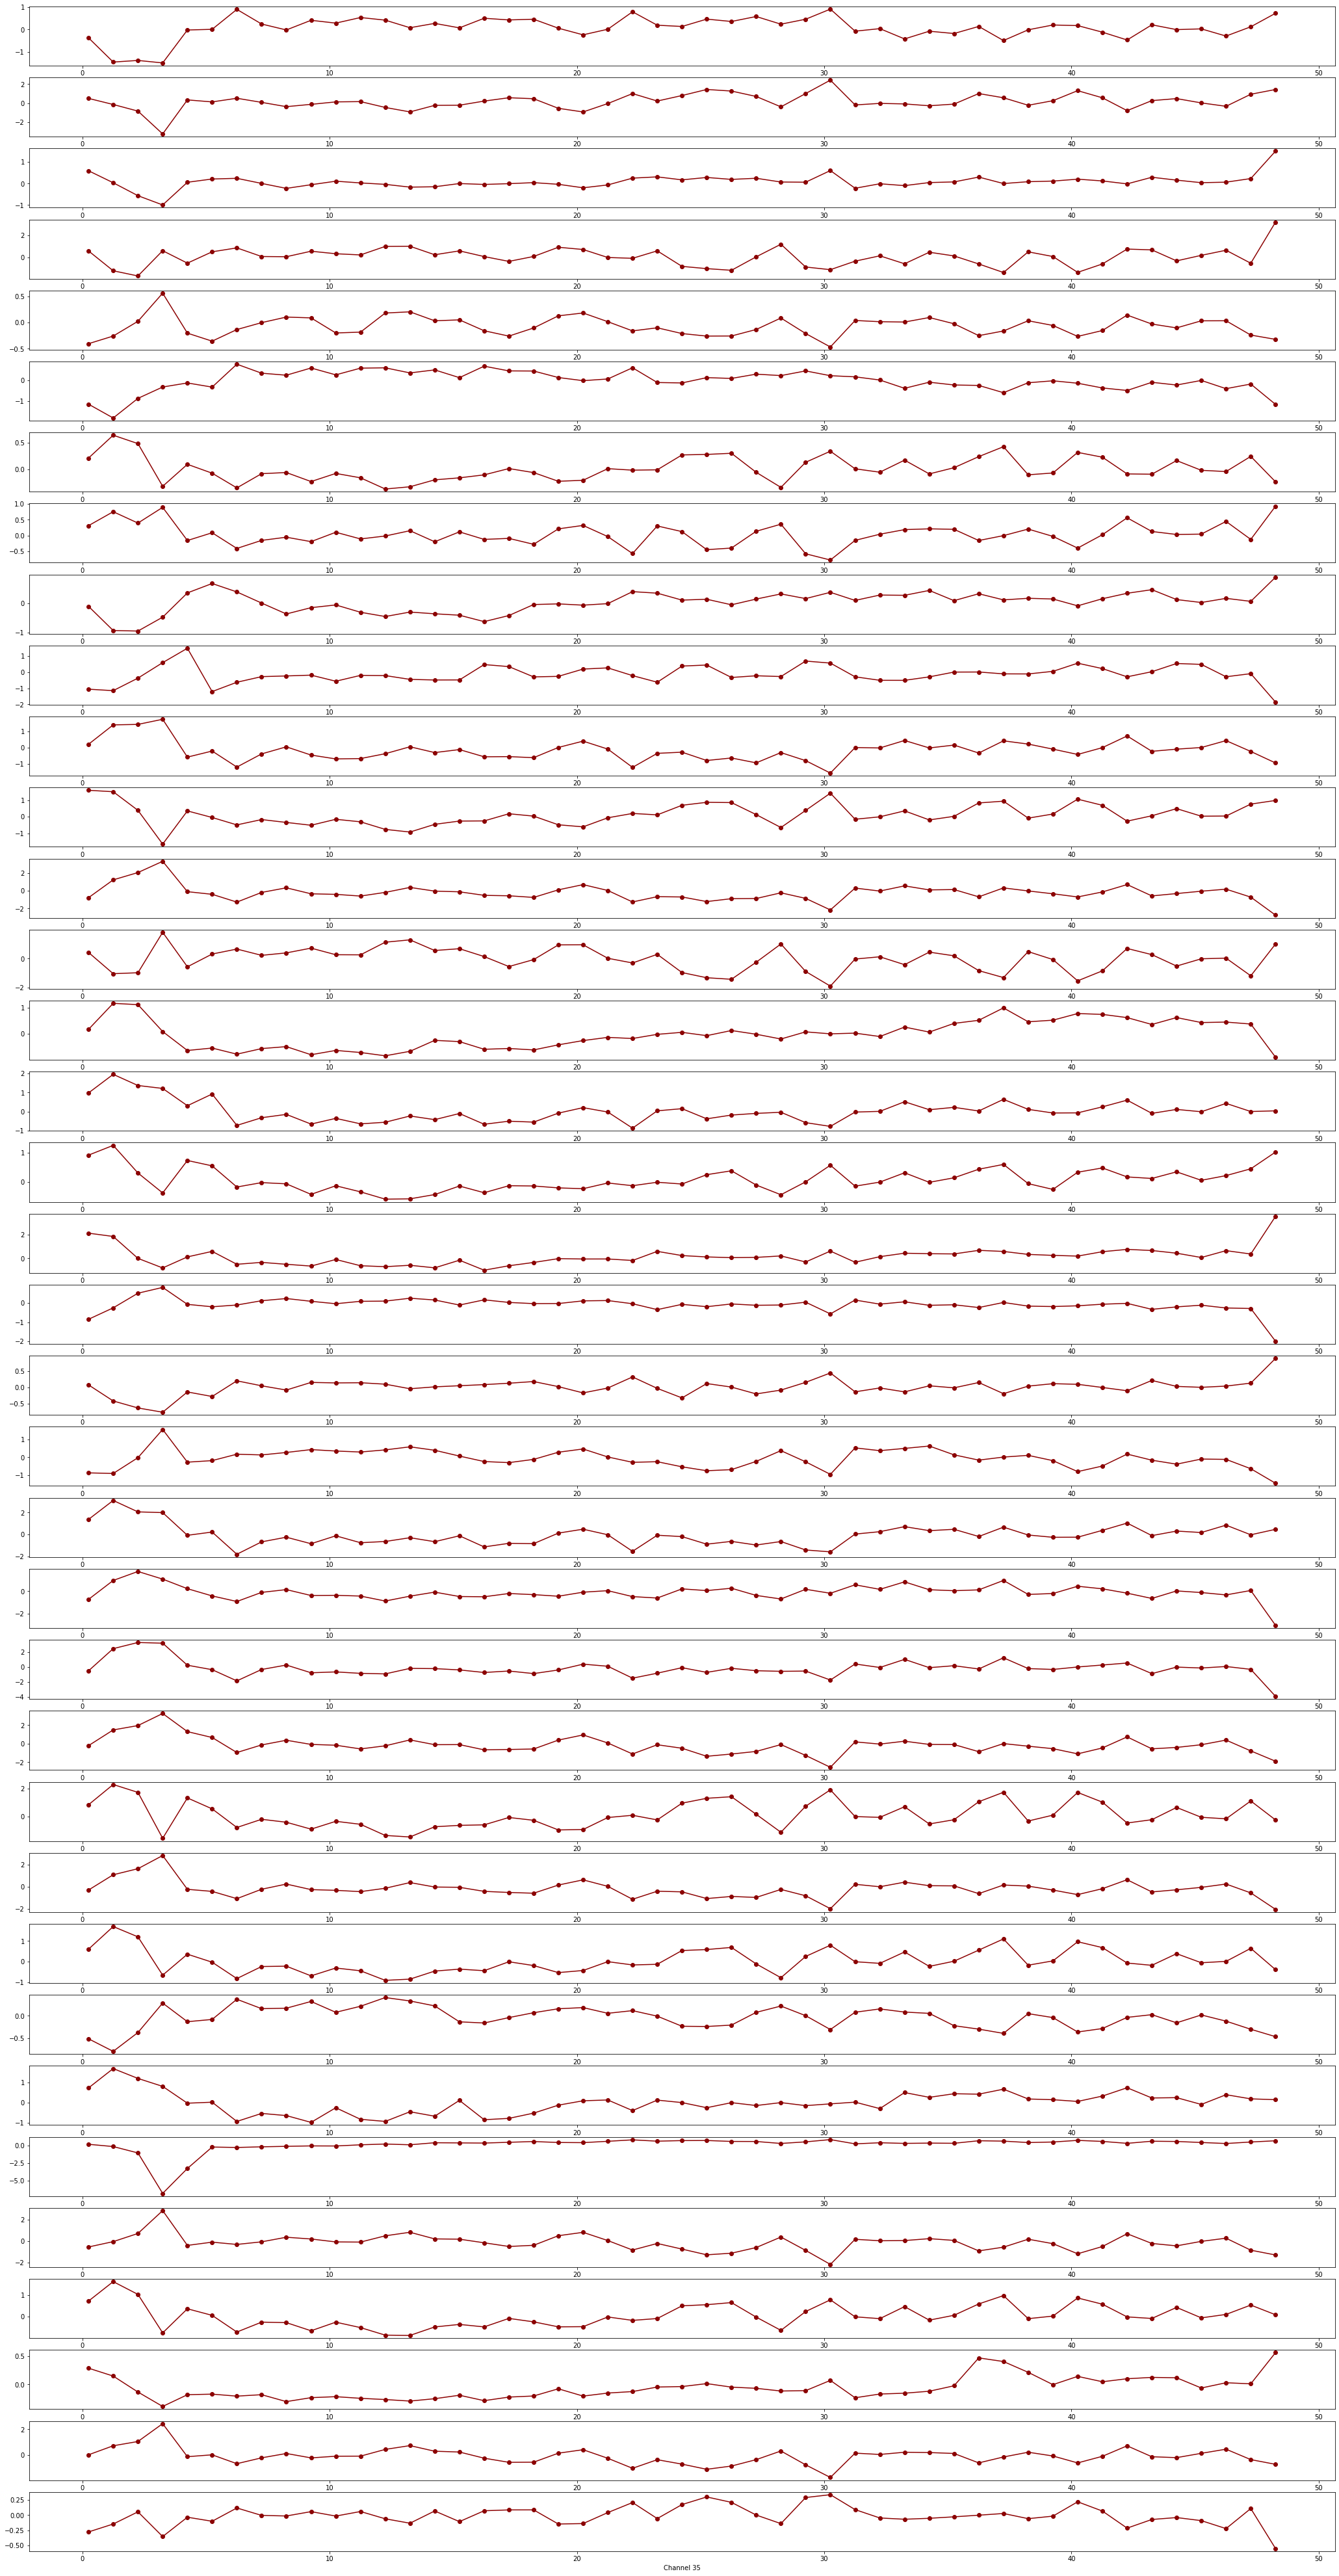

In [187]:
plot_instance(Z_raw_first, 
              test_inputs_first, 
              test_indices_first, 
              show_channels='all')

In [131]:
test_indices_first == channel

tensor([ True,  True,  True,  ..., False, False, False])

In [136]:
Z_raw_first.shape

torch.Size([1764])

In [74]:
# Custom TrainingLoop:
"""Training classes."""
import gc
import gpytorch
import torch
from torch.utils.data import DataLoader
import numpy as np
from src.utils.train_utils import augment_labels


class CustomTrainingLoop():
    """Training a model using a dataset."""

    def __init__(self, model, dataset, data_format, loss_fn, collate_fn, n_epochs, batch_size, virtual_batch_size, learning_rate,
                 n_mc_smps=1, max_root=25, weight_decay=1e-5, device='cuda', callbacks=None):
        """Training of a model using a dataset and the defined callbacks.

        Args:
            model: GP_Sig, competitor
            dataset: Dataset
            n_epochs: Number of epochs to train
            batch_size: Batch size
            learning_rate: Learning rate
            callbacks: List of callbacks
        """
        self.model = model
        self.dataset = dataset
        self.data_format = data_format
        self.loss_fn = loss_fn
        self.collate_fn = collate_fn
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.virtual_batch_size = virtual_batch_size
        self.learning_rate = learning_rate
        self.n_mc_smps = n_mc_smps
        self.max_root = max_root
        self.weight_decay = weight_decay
        self.device = device
        self.callbacks = callbacks if callbacks else []

    def _execute_callbacks(self, hook, local_variables):
        stop = False
        for callback in self.callbacks:
            # Convert return value to bool --> if callback doesn't return
            # anything we interpret it as False
            stop |= bool(getattr(callback, hook)(**local_variables))
        return stop

    def on_epoch_begin(self, local_variables):
        """Call callbacks before an epoch begins."""
        return self._execute_callbacks('on_epoch_begin', local_variables)

    def on_epoch_end(self, local_variables):
        """Call callbacks after an epoch is finished."""
        return self._execute_callbacks('on_epoch_end', local_variables)
    
    def on_batch_begin(self, local_variables):
        """Call callbacks before a batch is being processed."""
        self._execute_callbacks('on_batch_begin', local_variables)

    def on_batch_end(self, local_variables):
        """Call callbacks after a batch has be processed."""
        self._execute_callbacks('on_batch_end', local_variables)

    def on_train_end(self, local_variables):
        """Call callbacks after training is finished."""
        self._execute_callbacks('on_train_end', local_variables)

    # pylint: disable=W0641
    def __call__(self):
        """Execute the training loop."""
        model = self.model
        dataset = self.dataset
        n_epochs = self.n_epochs
        batch_size = self.batch_size
        virtual_batch_size = self.virtual_batch_size
        if virtual_batch_size is not None:
            virtual_scaling = virtual_batch_size / batch_size
            if virtual_batch_size == batch_size: #if virtual batch_size is 'inactive' / same as bs, set it to None
                virtual_batch_size = None
        learning_rate = self.learning_rate
        n_mc_smps = self.n_mc_smps
        collate_fn = self.collate_fn

        n_instances = len(dataset)
        train_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn,
                                  shuffle=True, pin_memory=True, num_workers=8) #drop_last=True)
        n_batches = len(train_loader)

        optimizer = torch.optim.Adam(
            model.parameters(), lr=learning_rate,
            weight_decay=self.weight_decay)

        epoch = 1
        for epoch in range(1, n_epochs+1):
            if self.on_epoch_begin(remove_self(locals())):
                break
            optimizer.zero_grad()
            for batch, d in enumerate(train_loader):
                #if we use mc sampling, expand labels to match multiple predictions
                if n_mc_smps > 1:
                    y_true = augment_labels(d['label'], n_mc_smps)
                else:
                    y_true = d['label']

                if self.data_format == 'GP':
                    #GP format of data:
                    inputs = d['inputs']
                    indices = d['indices']
                    values = d['values']
                    test_inputs = d['test_inputs']
                    test_indices = d['test_indices']

                    if self.device == 'cuda':
                        inputs  = inputs.cuda(non_blocking = True)
                        indices = indices.cuda(non_blocking = True)
                        values  = values.cuda(non_blocking = True)
                        test_inputs = test_inputs.cuda(non_blocking = True)
                        test_indices = test_indices.cuda(non_blocking = True)
                else:
                    raise NotImplementedError('Trainloop for other data formats not implemented yet.')

                self.on_batch_begin(remove_self(locals()))

                # Set model into training mode and feed forward
                model.train()

                if self.data_format == 'GP':
                    with gpytorch.settings.fast_pred_var(), gpytorch.settings.max_root_decomposition_size(self.max_root):
                        logits = model( inputs,
                                        indices,
                                        values,
                                        test_inputs,
                                        test_indices)

                #Compute Loss:
                if self.device == 'cuda':
                    y_true = y_true.flatten().cuda(non_blocking=True)
                else:
                    y_true = y_true.flatten()

                loss = self.loss_fn(logits, y_true)

                if virtual_batch_size is not None:
                    if (batch + 1) % virtual_scaling == 0:
                        # Optimize
                        optimizer.step()
                        optimizer.zero_grad()
                        # Call callbacks
                        self.on_batch_end(remove_self(locals()))
                    loss = loss / virtual_scaling
                    loss.backward()

                else:
                    # Optimize
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    # Call callbacks
                    self.on_batch_end(remove_self(locals()))
                
                # Clean memory
                torch.cuda.empty_cache()
                gc.collect()

            if self.on_epoch_end(remove_self(locals())):
                break
        self.on_train_end(remove_self(locals()))
